<a href="https://colab.research.google.com/github/busrayatlav/traffic_prediction_Berlin/blob/main/berlin_traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Required Libraries
Before starting the analysis, we need to ensure that all necessary libraries are installed.

In [ ]:
!pip install scikit-learn --upgrade
!pip install catboost tensorflow

### Importing Libraries
The essential libraries for data manipulation, visualization, and modeling are imported.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import joblib


### Mounting Google Drive
For data storage and retrieval, Google Drive is mounted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Defining File Paths
Paths for various datasets are defined for easier access.

In [ ]:
data_paths = {
    "bank_holidays": '/content/drive/MyDrive/datasets/bank_holidays.csv',
    "routes": '/content/drive/MyDrive/datasets/routes.csv',
    "detectors": '/content/drive/MyDrive/datasets/detectors.csv',
    "construction": '/content/drive/MyDrive/datasets/construction.csv',
    "weather": '/content/drive/MyDrive/datasets/weather.csv',
    "traffic_september": '/content/drive/MyDrive/datasets/traffic_2024_09.csv',
    "traffic_october": '/content/drive/MyDrive/datasets/traffic_2024_10.csv',
    "traffic_november": '/content/drive/MyDrive/datasets/traffic_2024_11.csv',
}

### Loading CSV Files
A function is defined to dynamically load CSV files with the appropriate separator.

In [ ]:
def load_csv(filepath, sep=None):
    try:
        if sep is None:
            with open(filepath, 'r') as file:
                dialect = csv.Sniffer().sniff(file.read(1024))
            sep = dialect.delimiter
        df = pd.read_csv(filepath, sep=sep)
        print(f"File loaded successfully: {filepath}")
        return df
    except Exception as e:
        print(f"Error loading file {filepath}: {e}")
        return None


### Loading Data
The datasets for traffic, weather, and construction data are loaded into individual dataframes.

In [ ]:
traffic_september = load_csv(data_paths['traffic_september'], sep=';')
traffic_october = load_csv(data_paths['traffic_october'], sep=';')
traffic_november = load_csv(data_paths['traffic_november'], sep=';')
weather = load_csv(data_paths['weather'], sep=';')
construction = load_csv(data_paths['construction'], sep=';')
bank_holidays = load_csv(data_paths['bank_holidays'], sep=';')
detectors = load_csv(data_paths['detectors'], sep=';')


### Combining Traffic Data
Traffic data from three months is concatenated into a single DataFrame for unified analysis.

In [ ]:
traffic_data = pd.concat([traffic_september, traffic_october, traffic_november], ignore_index=True)
print("Traffic data columns:", traffic_data.columns)


Traffic data columns: Index(['detector_id', 'date', 'hour', 'quality', 'total_vehicle_count_hourly',
       'average_vehicle_speed_hourly', 'car_count_hourly',
       'average_car_speed_hourly', 'truck_count_hourly',
       'average_truck_speed_hourly'],
      dtype='object')


### Creating a Timestamp Column
The `date` and `hour` columns are combined to create a `timestamp` column, which helps in time-series analysis.

In [ ]:
if 'date' in traffic_data.columns and 'hour' in traffic_data.columns:
    traffic_data['timestamp'] = pd.to_datetime(traffic_data['date'].astype(str) + ' ' + traffic_data['hour'].astype(str) + ':00:00')
else:
    raise KeyError("The required columns 'date' and 'hour' are missing in traffic data.")

traffic_data['date'] = traffic_data['timestamp'].dt.date
traffic_data['hour'] = traffic_data['timestamp'].dt.hour


### Adding Holiday Information
Holiday information is merged to mark holidays in the dataset.

In [ ]:
bank_holidays['date'] = pd.to_datetime(bank_holidays['date']).dt.date
traffic_data['is_holiday'] = traffic_data['date'].isin(bank_holidays['date']).astype(int)


### Merging Detector Data
Detector metadata is added to the traffic dataset using a join operation.

In [ ]:
merged_data = traffic_data.merge(detectors, on='detector_id', how='left')


### Adding Weather Information
Weather data is merged based on date and hour to capture environmental conditions.

In [ ]:
weather['date'] = pd.to_datetime(weather['date']).dt.date
merged_data = merged_data.merge(weather, on=['date', 'hour'], how='left')


### Adding Construction Effects
Construction information is added to the dataset by marking rows affected by ongoing road work.

In [ ]:
construction['validity_from'] = pd.to_datetime(construction['validity_from'])
construction['validity_to'] = pd.to_datetime(construction['validity_to'])
merged_data['is_under_construction'] = merged_data.apply(
    lambda row: any((row['timestamp'] >= construction['validity_from']) &
                    (row['timestamp'] <= construction['validity_to'])),
    axis=1
)


### Adding Weekend Information
A boolean column is added to indicate whether a record corresponds to a weekend.

In [ ]:
merged_data['is_weekend'] = merged_data['timestamp'].dt.weekday.isin([5, 6]).astype(int)

### Handling Missing Values
All missing values in the dataset are replaced with zeroes.

In [ ]:
merged_data = merged_data.fillna(0)


### Sampling the Data
To optimize performance, a 20% random sample of the dataset is taken.

In [ ]:
merged_data = merged_data.sample(frac=0.2, random_state=42)  # %20 örnek alınması

### Defining Features and Target Variable
Features (`X`) and the target variable (`y`) are defined for predictive modeling.

In [ ]:
X = merged_data[['temperature', 'wind_speed', 'total_vehicle_count_hourly', 'latitude', 'longitude',
                 'is_holiday', 'is_under_construction', 'is_weekend']]
y = merged_data['average_vehicle_speed_hourly']


### Splitting the Data
The data is split into training and testing subsets for model evaluation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Scaling Features
The features are scaled for better model performance using standardization.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Modeling and Clustering
#### 1. Linear Regression
Linear regression is used as a baseline model to predict traffic speeds.

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression - MSE: {lr_mse}, R2: {lr_r2}")
joblib.dump(lr_model, 'lr_model.pkl')


Linear Regression - MSE: 154.67094667544546, R2: 0.006748564303179605


['lr_model.pkl']

#### 2. K-Means Clustering
K-Means is used to identify distinct traffic patterns in the data.

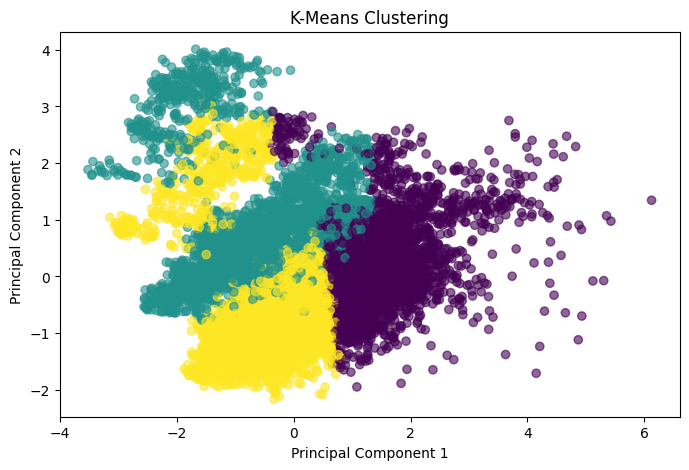

['kmeans_model.pkl']

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)
kmeans_labels = kmeans.predict(X_test_scaled)
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
joblib.dump(kmeans, 'kmeans_model.pkl')


#### 3. Random Forest
A Random Forest model is trained to handle non-linear relationships effectively.

In [ ]:
# 3. Random Forest
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest - MSE: {rf_mse}, R2: {rf_r2}")
joblib.dump(rf_model, 'rf_model.pkl')


Random Forest - MSE: 35.46150697069943, R2: 0.7722766074191769


['rf_model.pkl']

#### 4. XGBoost
XGBoost is trained for further comparison with other models.

In [ ]:
xgb_model = XGBRegressor(n_estimators=10, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"XGBoost - MSE: {xgb_mse}, R2: {xgb_r2}")
joblib.dump(xgb_model, 'xgb_model.pkl')


XGBoost - MSE: 56.61518859863281, R2: 0.6364338397979736


['xgb_model.pkl']

#### 5. Support Vector Machine (SVM)
Linear SVM is applied to explore its performance on this dataset.

In [ ]:
svm_model = SVR(kernel='linear', C=0.1, epsilon=0.2)
svm_model.fit(X_train_scaled[:1000], y_train[:1000])
svm_pred = svm_model.predict(X_test_scaled[:500])
svm_mse = mean_squared_error(y_test[:500], svm_pred)
svm_r2 = r2_score(y_test[:500], svm_pred)
print(f"SVM - MSE: {svm_mse}, R2: {svm_r2}")
joblib.dump(svm_model, 'svm_model.pkl')


SVM - MSE: 147.77760139775282, R2: -0.02046702404275913


['svm_model.pkl']

#### 6. Light GBM
LightGBM, a gradient boosting model, is used to evaluate its effectiveness.

In [ ]:
lgbm_model = LGBMRegressor(n_estimators=10, random_state=42)
lgbm_model.fit(X_train_scaled, y_train)
lgbm_pred = lgbm_model.predict(X_test_scaled)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)
print(f"Light GBM - MSE: {lgbm_mse}, R2: {lgbm_r2}")
joblib.dump(lgbm_model, 'lgbm_model.pkl')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 50780, number of used features: 7
[LightGBM] [Info] Start training from score 41.603584
Light GBM - MSE: 75.2609279481382, R2: 0.5166964039263198


['lgbm_model.pkl']

#### 7. Neural Network
A simple neural network model is applied for further exploration.

In [ ]:
nn_model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=100, random_state=42)
nn_model.fit(X_train_scaled, y_train)
nn_pred = nn_model.predict(X_test_scaled)
nn_mse = mean_squared_error(y_test, nn_pred)
nn_r2 = r2_score(y_test, nn_pred)
print(f"Neural Network - MSE: {nn_mse}, R2: {nn_r2}")
joblib.dump(nn_model, 'nn_model.pkl')


Neural Network - MSE: 127.47496451822633, R2: 0.1813931818183534


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


['nn_model.pkl']

#### 8. CatBoost Regressor
CatBoost, a gradient boosting model optimized for categorical data, is applied.

In [ ]:
catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)
catboost_mse = mean_squared_error(y_test, catboost_pred)
catboost_r2 = r2_score(y_test, catboost_pred)
print(f"CatBoost Regressor - MSE: {catboost_mse}, R2: {catboost_r2}")
joblib.dump(catboost_model, 'catboost_model.pkl')


CatBoost Regressor - MSE: 52.51498728232498, R2: 0.6627641607235975


['catboost_model.pkl']

### Evaluation and Comparison
#### Correlation Analysis
A heatmap is used to visualize feature correlations.

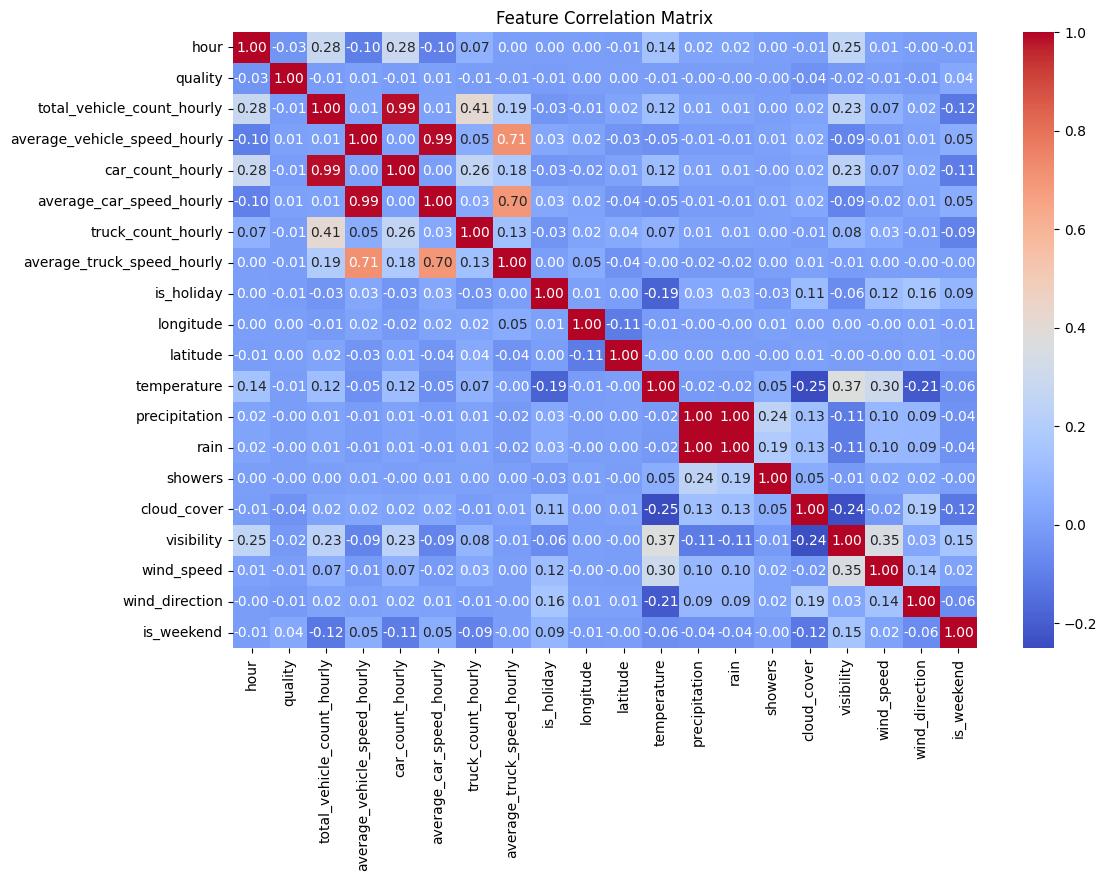

In [ ]:
numeric_columns = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


#### Spatial Analysis
Traffic speed is visualized geographically using scatter plots.

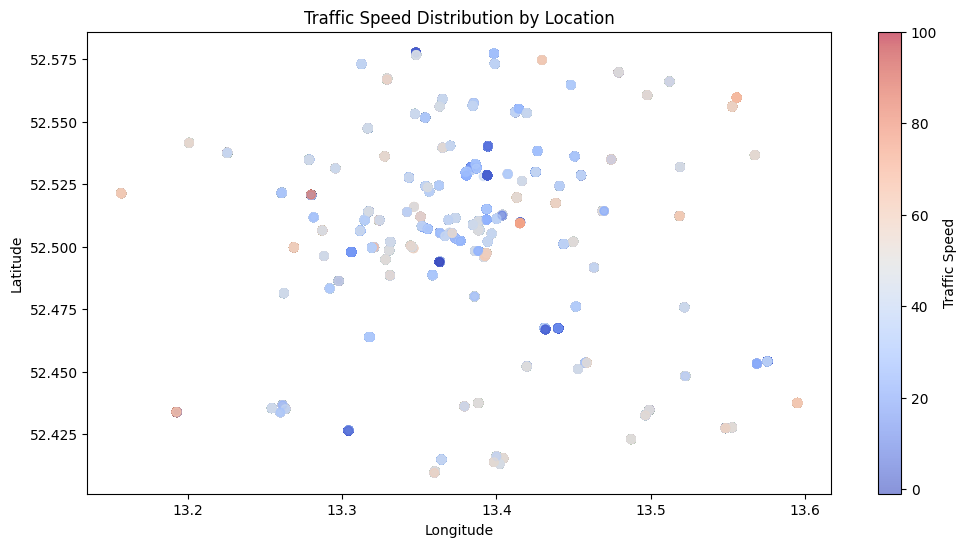

In [ ]:
plt.figure(figsize=(12, 6))
mappable = plt.scatter(merged_data['longitude'], merged_data['latitude'],
                       c=merged_data['average_vehicle_speed_hourly'],
                       cmap='coolwarm', alpha=0.6)
plt.title("Traffic Speed Distribution by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(mappable, label="Traffic Speed")
plt.show()


#### Scenario Analysis
Comparison of average speeds during holidays and non-holidays.

In [ ]:
temp_holiday = merged_data[merged_data['is_holiday'] == 1]['average_vehicle_speed_hourly'].mean()
temp_non_holiday = merged_data[merged_data['is_holiday'] == 0]['average_vehicle_speed_hourly'].mean()
print(f"Average Speed on Holidays: {temp_holiday}")
print(f"Average Speed on Non-Holidays: {temp_non_holiday}")


Average Speed on Holidays: 42.98055169676523
Average Speed on Non-Holidays: 41.50059037938293


#### Model Comparison
Model performance is compared using MSE and R² values.

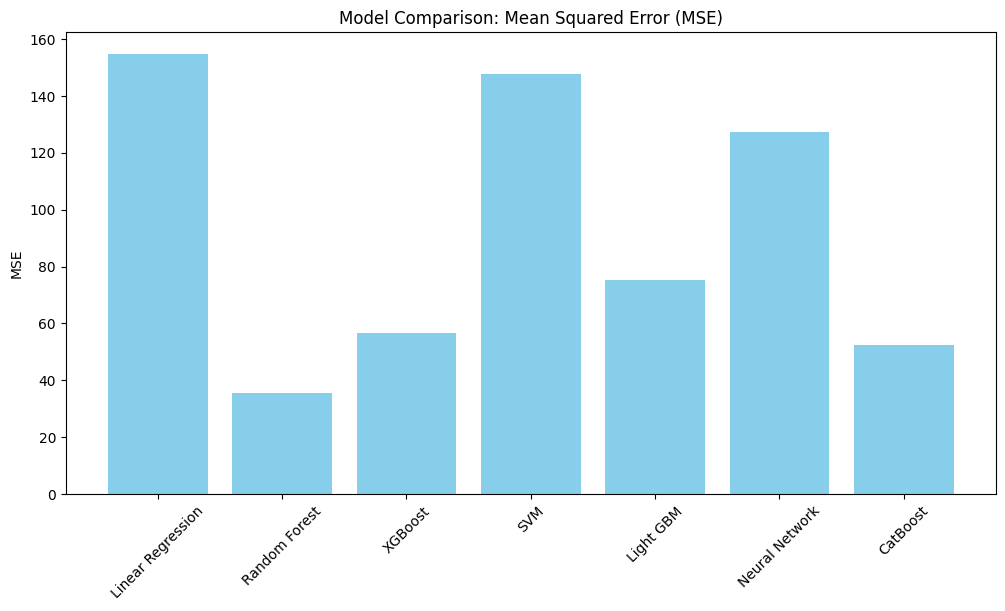

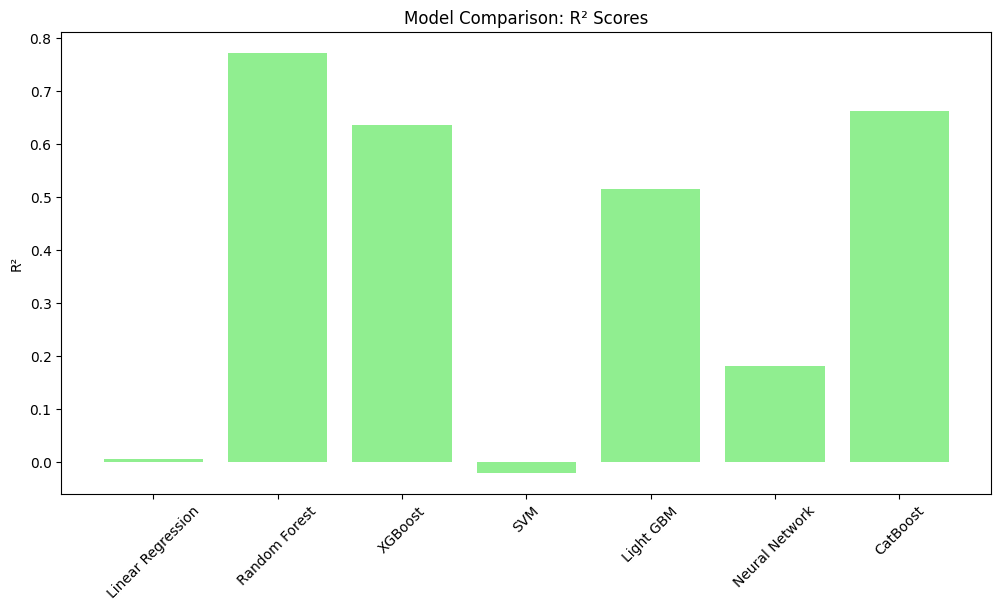

In [ ]:
model_names = ["Linear Regression", "Random Forest", "XGBoost", "SVM", "Light GBM", "Neural Network", "CatBoost"]
mse_values = [lr_mse, rf_mse, xgb_mse, svm_mse, lgbm_mse, nn_mse, catboost_mse]
plt.figure(figsize=(12, 6))
plt.bar(model_names, mse_values, color='skyblue')
plt.title("Model Comparison: Mean Squared Error (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()

r2_values = [lr_r2, rf_r2, xgb_r2, svm_r2, lgbm_r2, nn_r2, catboost_r2]
plt.figure(figsize=(12, 6))
plt.bar(model_names, r2_values, color='lightgreen')
plt.title("Model Comparison: R² Scores")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.show()